## Mean SpeedNorm by Weightclass grouped by Track and Distance

From pure speculation, a heavier greyhound should be capable of withstanding interference from other dogs and hence their performance should be affected less compared to a smaller, lighter greyhound. A heavier greyhound generally has more muscle, but this does increase the inertia of the greyhound - Are these quantities in direct proportion to one another? If I were to compare greyhounds to olympic sprinters (which is a huge stretch in terms assumptions), there's probably a sweet spot between light and heavy for maximising undisturbed speed.

We classify each greyhound into one of ten weight quantiles for each weight, the average performance of each weight class (measured by SpeedNorm) is then compared for each Track and Distance (with a large enough sample size). I'm speculating that some TrackDist cause more interference than others (as seen in speednorm-by-trackdist), and hence being heavier would be beneficial.

Interestingly, the relative weight is weakly correlated to the relative speed (by race). Thus, the individual performance of a greyhound is strongly dependent on its weight (but not its weight relative to the other greyhounds in the race). Hence, the weight advantage must not be due to interference properties, but simply the power output of the greyhound.

----

### 0. Read cleansed data

In [1]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')

display(df_raw)

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763162,614057722,4,INFAMOUS ANGEL,3,3,25.0,NaN,12.25,0.14,2,0,7.10,18.45,0.0,734778635,69407,P WORTHINGTON,302,Qualifying Trial,Mandurah,2,Mandurah302,2021-11-30
763163,576142623,1,ROISIN MONELLI,1,1,29.1,NaN,1.00,NaN,11,0,6.73,23.43,0.0,734778636,130513,D HOBBY,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30
763164,540582677,2,RAPIDO CHA CHA,7,7,26.1,NaN,1.00,1.14,32,0,6.92,23.51,0.0,734778636,130351,R WESTWORTH,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30
763165,580792922,3,TIGGERLONG FOOT,5,5,25.5,NaN,6.00,4.86,23,0,6.89,23.85,0.0,734778636,102994,S BEARD,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30


### Determine average SpeedNorm for each weight class at various TrackDist values

In [2]:
df = df_raw.copy()

# Calculate average speed
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise speed by track
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Break weights into 10 quantiles
df['WeightQuantile'] = pd.qcut(df['Weight'], 10, labels=False)

df = df.groupby(["TrackDist", "WeightQuantile"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', np.mean),
                                                                     SpeedNorm_std=('SpeedNorm', np.std),
                                                                     SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with large enough sample sizes for all weight classes
df["MinSampleSize"] = df.groupby('TrackDist')['SampleSize'].transform(lambda x: min(x))
df = df[df["MinSampleSize"] >= 1000]

# Correlation?
display(df.WeightQuantile.corr(df.SpeedNorm_mean))

display(df)

0.8311129680326342

,TrackDist,WeightQuantile,SpeedNorm_mean,SpeedNorm_std,SampleSize,MinSampleSize
10,Albion Park395,0,-0.077152,1.006547,2924,1055
11,Albion Park395,1,-0.042572,0.963473,2084,1055
12,Albion Park395,2,0.036549,0.947232,1824,1055
13,Albion Park395,3,-0.079062,1.126832,1584,1055
14,Albion Park395,4,0.017880,0.938793,1744,1055
...,...,...,...,...,...,...
1201,Warragul400,5,0.037134,1.007515,2056,1791
1202,Warragul400,6,0.104083,1.001370,2462,1791
1203,Warragul400,7,0.123003,0.995396,2498,1791
1204,Warragul400,8,0.139444,0.990016,2130,1791


### Plot average SpeedNorm for each weight class by Track and Distance

<AxesSubplot:xlabel='WeightQuantile', ylabel='SpeedNorm_mean'>

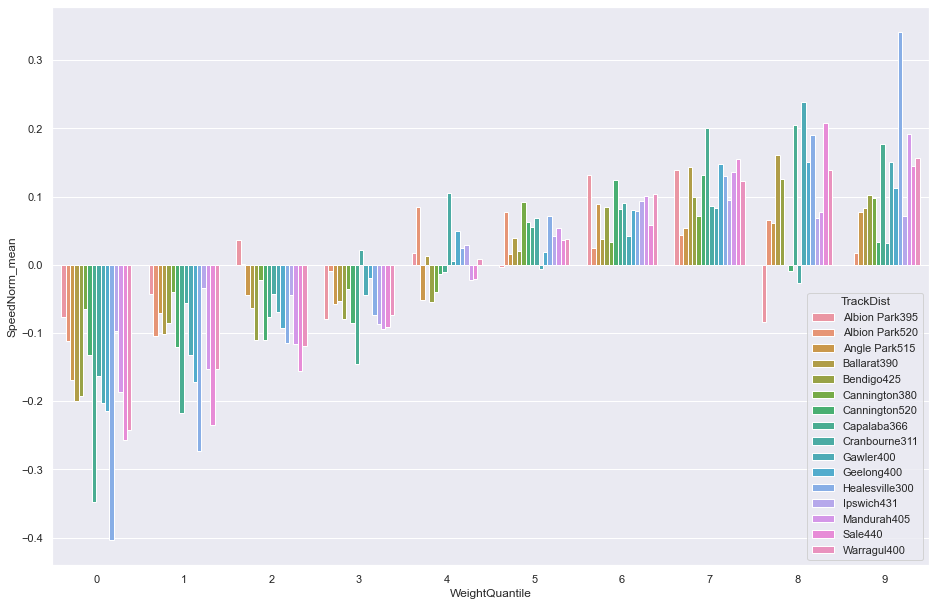

In [3]:
# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
sns.barplot(data=df, x="WeightQuantile", y="SpeedNorm_mean", hue="TrackDist")

### Correlation between relative weight and relative speed?

In [14]:
# Copy
df = df_raw.copy()

# Calculate speed
df['Speed'] = df['Distance']/df['RunTime']

# Calculate z-score of weight and speed for each race
df['Speed_scale'] = df.groupby('FasttrackRaceId')['Speed'].transform(lambda x: (x - min(x))/(max(x) - min(x)))
df['Weight_scale'] = df.groupby('FasttrackRaceId')['Weight'].transform(lambda x: (x - min(x))/(max(x) - min(x)))

display(df)

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate,Speed,Speed_scale,Weight_scale
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,17.445918,1.000000,0.260274
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,17.349063,0.662966,1.000000
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,17.283097,0.433417,0.000000
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,17.223562,0.226246,0.917808
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,17.211704,0.184983,0.465753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763162,614057722,4,INFAMOUS ANGEL,3,3,25.0,NaN,12.25,0.14,2,0,7.10,18.45,0.0,734778635,69407,P WORTHINGTON,302,Qualifying Trial,Mandurah,2,Mandurah302,2021-11-30,16.368564,0.000000,0.190000
763163,576142623,1,ROISIN MONELLI,1,1,29.1,NaN,1.00,NaN,11,0,6.73,23.43,0.0,734778636,130513,D HOBBY,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30,17.285531,1.000000,1.000000
763164,540582677,2,RAPIDO CHA CHA,7,7,26.1,NaN,1.00,1.14,32,0,6.92,23.51,0.0,734778636,130351,R WESTWORTH,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30,17.226712,0.806769,0.166667
763165,580792922,3,TIGGERLONG FOOT,5,5,25.5,NaN,6.00,4.86,23,0,6.89,23.85,0.0,734778636,102994,S BEARD,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30,16.981132,0.000000,0.000000


In [17]:
display(df['Speed_scale'].corr(df['Weight_scale']))

0.056469505917709405